In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            # 'epochs_per_task': 5,
            'epochs_per_task': 15,
            'per_task_examples': np.inf,
            # 'per_task_examples': 2000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:4' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.001,
            'metric' : "DP",
            'lambda': 0.1,
            'lambda_old': 0.0,

            # postprocessing
            # "post_processing": "eps_fairness"

              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=0_epoch=15_lr=0.001_tau=10.0_alpha=0.001_lmbd_0.1_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
from torchvision.transforms.functional import to_pil_image
from cl_gym.benchmarks.transforms import MNIST_MEAN, MNIST_STD
COLOR_MAP = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (1, 1, 0),
    3: (0, 0, 1),
    4: (1, 0.65, 0),
    5: (0.5, 0, 0.5),
    6: (0, 1, 1),
    7: (1, 0.75, 0.8),
    8: (0.8, 1, 0),
    9: (.588, .294, 0.)
}

r = (1 - 0.1913)
color_values = np.array(list(COLOR_MAP.values()))
m_rgb = color_values.mean(axis=0)
std_rgb = color_values.std(axis=0)

bmnist_mean = [r*m + MNIST_MEAN[0] for m in m_rgb]
bmnist_std = [(r*s**2+(1-r)*MNIST_STD[0]**2+r*(1-r)*(bmnist_mean[i] - m_rgb[i])**2)**0.5 for i, s in enumerate(std_rgb)]

unnormalize = torchvision.transforms.Normalize([-m/s for m, s in zip(bmnist_mean, bmnist_std)], [1/s for s in bmnist_std])
sample_idx = 95
to_pil_image(unnormalize(benchmark.trains[2][sample_idx][0]), mode="RGB")

In [5]:
# target_label = 0
# incremental_step = 1
# # cat_img = torch.cat([img for img in benchmark.trains[incremental_step].inputs[benchmark.trains[incremental_step].targets == target_label][20:30]], dim=2)
# cat_img = torch.cat([img for img, target, *_ in benchmark.tests[incremental_step]][20:30], dim=2)
# to_pil_image(unnormalize(cat_img), mode="RGB")

In [6]:
from trainers import FairContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector
from metrics import MetricCollector2

from algorithms import Heuristic3
from algorithms.fairl import FaIRL
from algorithms.icarl import iCaRL
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
# backbone = ResNet18Small2(
#         input_dim=input_dim, 
#         output_dim=num_classes,
#         class_idx=class_idx,
#         config=params
#     ).to(params['device'])
# algorithm = iCaRL(backbone, benchmark, params, requires_memory=True)
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])
# metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
#                                                         eval_interval='epoch',
#                                                         epochs_per_task=params['epochs_per_task'])
# from trainers.baselines import BaseMemoryContinualTrainer as ContinualTrainer
from trainers.baselines import BaseContinualTrainer as ContinualTrainer

# trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])
# 
trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [7]:
from algorithms.optimization import absolute_and_nonabsolute_minsum_LP_solver
solver = absolute_and_nonabsolute_minsum_LP_solver
converter = algorithm.converter_LP_absolute_additional_DP_v2

params['solver'] = solver
params['converter'] = converter

In [8]:
algorithm.params['dataset'] == "BiasedMNIST"

True

In [9]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.8271127393688753, 'loss': 0.002176862856456856, 'std': 0.04737705654949209, 'EER': -1, 'EO': [0.4595588235294118, 0.25], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6452205882352942, 'classwise_accuracy': {1: array([ 885, 1135]), 0: array([857, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 591, 0: 488}, 'class_pred_count_s1': {1: 417, 0: 619}, 'class_pred_count': {1: 1008, 0: 1107}, 'count_s0': 1079, 'count_s1': 1036, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.9061584105007642, 'loss': 0.0011422632222479962, 'std': 0.016290569091072515, 'EER': -1, 'EO': [0.1544715447154471, 0.22977941176470584], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.8078745217599235, 'classwise_accuracy': {0: array([904, 980]), 1: array([1010, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 488, 1: 591}, 'class_pred_count_s1': {1: 495, 0: 541}, 'class_pred_count': {0: 1

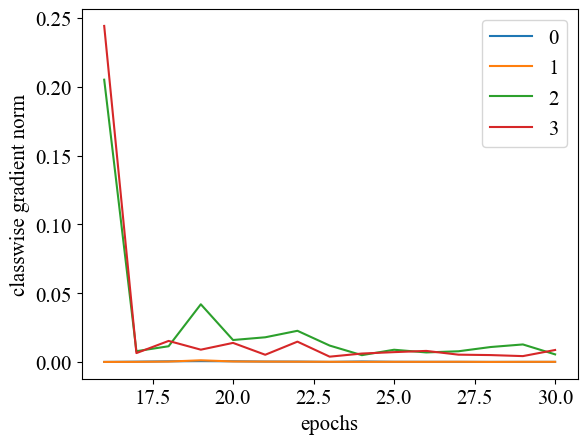

---------------------------- Task 3 -----------------------
loss_group=tensor([[7.1093e-05, 5.2372e-05, 7.5853e-02, 1.1297e-01, 1.0748e+01, 1.0950e+01,
         4.2405e-04, 3.6082e-04, 1.0666e+00, 6.6387e-01, 1.1112e+01, 1.2126e+01]])
Elapsed time(grad):6.319
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):10.003
Fairness:[ 0.00149958 -0.01140241  0.03982752  0.04892489  0.          0.        ]
len(updated_seq_indices)=11263
Elapsed time(etc):0.396
[31] Eval metrics for task 1 >> {'accuracy': 0.9477546525218017, 'loss': 0.0007985675976067852, 'std': 0.016121999460577185, 'EER': -1, 'EO': [0.06830708171593503, 0.09944355591096898], 'DP': -1, 'accuracy_s0': 0.9890866411472636, 'accuracy_s1': 0.9052113223338116, 'classwise_accuracy': {1: array([1094, 1135]), 0: array([913, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 589, 0: 479, 5: 7, 3: 2, 2: 1, 4: 1}, 'class_pred_count_s1': {1: 506, 0: 434, 4: 18, 5: 21, 2: 25, 3: 32}, 'class_pred_count': {1: 1095, 

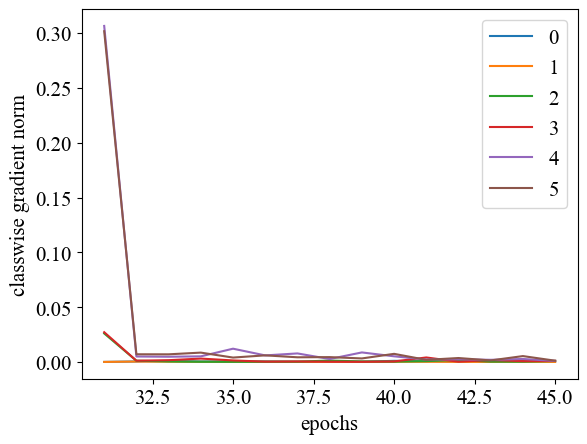

---------------------------- Task 4 -----------------------
loss_group=tensor([[1.6652e-03, 9.3855e-05, 8.6071e-04, 1.9428e-03, 3.7436e-03, 1.1647e-02,
         1.3018e+01, 8.4036e+00, 2.8690e-03, 2.8728e-03, 2.9654e-03, 2.0938e-02,
         1.1029e-01, 6.8863e-01, 1.3997e+01, 1.2920e+01]])
Elapsed time(grad):5.916
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):15.737
Fairness:[-0.0026302   0.00422528 -0.01356415  0.01993006  0.01669769  0.01203081
  0.          0.        ]
len(updated_seq_indices)=12183
Elapsed time(etc):0.617
[46] Eval metrics for task 1 >> {'accuracy': 0.9253303964757709, 'loss': 0.001384900542015725, 'std': 0.0253303964757709, 'EER': -1, 'EO': [0.09235032845625557, 0.08489937358389987], 'DP': -1, 'accuracy_s0': 0.9687734043438463, 'accuracy_s1': 0.8801485533237685, 'classwise_accuracy': {1: array([1079, 1135]), 0: array([882, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 588, 0: 460, 5: 23, 3: 5, 6: 1, 7: 1, 4: 1}, 'class_pred_c

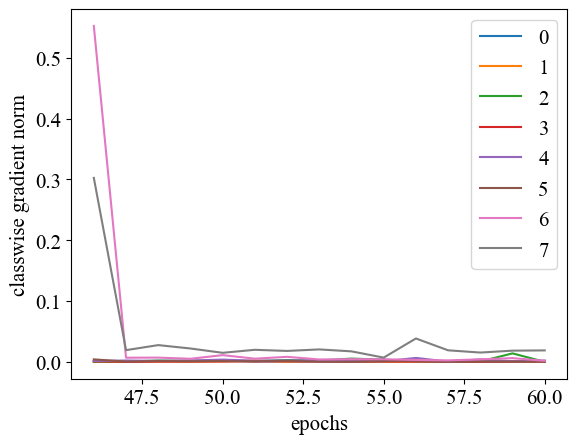

---------------------------- Task 5 -----------------------
loss_group=tensor([[6.7264e-04, 5.2680e-04, 2.8380e-03, 8.4472e-04, 6.5251e-03, 9.1481e-04,
         4.7345e-03, 6.4893e-02, 1.2624e+01, 1.6570e+01, 2.2294e-03, 5.1080e-03,
         7.1278e-03, 3.5323e-03, 2.4763e-02, 1.9049e-02, 3.8787e-01, 9.5129e-02,
         1.3801e+01, 1.5137e+01]])
Elapsed time(grad):5.386
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):17.686
Fairness:[-1.69723522e-04 -5.07990166e-04  5.78392494e-04 -4.28762341e-04
  2.75260052e-05  1.58222838e-03  4.91626467e-03 -8.07633132e-04
  0.00000000e+00  0.00000000e+00]
len(updated_seq_indices)=11800
Elapsed time(etc):0.662
[61] Eval metrics for task 1 >> {'accuracy': 0.895788006832689, 'loss': 0.001985100045553618, 'std': 0.02844106805717883, 'EER': -1, 'EO': [0.1333762565940082, 0.19075703052112492], 'DP': -1, 'accuracy_s0': 0.9756352112285374, 'accuracy_s1': 0.8135685676709707, 'classwise_accuracy': {1: array([1049, 1135]), 0: arr

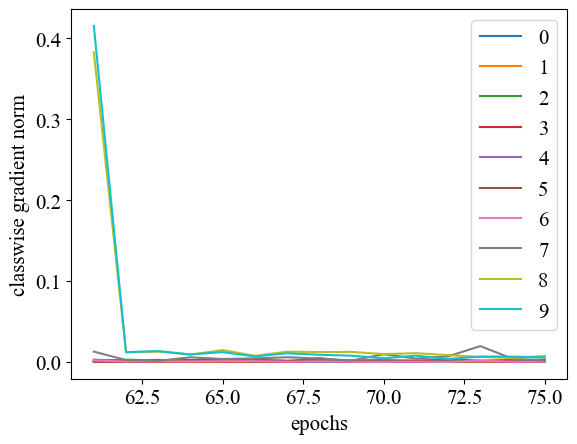

final avg-acc 0.8340816628375158
final avg-forget 0.09944810618987412


In [10]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [11]:
import copy
task_weight = copy.deepcopy(algorithm.weight_all)

num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out


binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})




task:2
task:3
task:4
task:5


In [12]:
binned_weight

{2: [{0: {1.0: 11521}, 1: {1.0: 568}},
  {0: {0.05: 8588, 0.45: 1, 0.95: 1, 1.0: 2931}, 1: {0.05: 37, 1.0: 531}},
  {0: {0.05: 10068, 0.3: 1, 1.0: 1452}, 1: {0.05: 164, 1.0: 404}},
  {0: {0.05: 9680, 0.95: 1, 1.0: 1840}, 1: {0.05: 156, 1.0: 412}},
  {0: {0.05: 8375, 0.1: 1, 0.85: 1, 1.0: 3144}, 1: {0.05: 289, 1.0: 279}},
  {0: {0.05: 10570, 0.8: 1, 1.0: 950}, 1: {0.05: 135, 1.0: 433}},
  {0: {0.05: 6465, 0.15: 1, 0.65: 1, 0.7: 1, 1.0: 5053},
   1: {0.05: 280, 1.0: 288}},
  {0: {0.05: 10077, 0.5: 1, 0.7: 1, 1.0: 1442}, 1: {0.05: 99, 1.0: 469}},
  {0: {0.05: 9020, 0.65: 1, 1.0: 2500}, 1: {0.05: 257, 1.0: 311}},
  {0: {0.05: 8333, 1.0: 3188}, 1: {0.05: 215, 1.0: 353}},
  {0: {0.05: 6498, 0.7: 1, 1.0: 5022}, 1: {0.05: 269, 1.0: 299}},
  {0: {0.05: 5542, 0.9: 1, 1.0: 5978}, 1: {0.05: 208, 0.55: 1, 1.0: 359}},
  {0: {0.05: 5629, 0.25: 1, 0.8: 1, 0.95: 1, 1.0: 5889},
   1: {0.05: 242, 1.0: 326}},
  {0: {0.05: 5860, 0.65: 1, 0.9: 1, 1.0: 5659}, 1: {0.05: 220, 1.0: 348}},
  {0: {0.05: 6140, 0.2

In [13]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.997, 0.   , 0.   , 0.   , 0.   ],
       [0.967, 0.866, 0.   , 0.   , 0.   ],
       [0.928, 0.84 , 0.897, 0.   , 0.   ],
       [0.91 , 0.826, 0.825, 0.935, 0.   ],
       [0.876, 0.77 , 0.756, 0.894, 0.874]])

In [14]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.9018642654368273

In [15]:
[np.round(x, 3) for x in metric_manager_callback.meters['EO'].compute_overall()]

[0.007, 0.152, 0.171, 0.169, 0.236]

In [16]:
np.mean(metric_manager_callback.meters['EO'].compute_overall())

0.14706698384633388

In [17]:
[np.round(x, 3) for x in metric_manager_callback.meters['DP'].compute_overall()]

[0.011, 0.009, 0.012, 0.007, 0.01]

In [18]:
np.mean(metric_manager_callback.meters['DP'].compute_overall())

0.009767235820775447

In [19]:
task_id = 2

print(f"{task_id=}")
print(f"sensitive samples / all samples = {(benchmark.trains[task_id].sensitives != benchmark.trains[task_id].targets).sum().item()} / {benchmark.trains[task_id].sensitives.shape[0]}")

updated_seq_indices = benchmark.seq_indices_train[task_id]
print(f"sensitive samples / selected samples = {(benchmark.trains[task_id].sensitives[updated_seq_indices] != benchmark.trains[task_id].targets[updated_seq_indices]).sum().item()} / {len(updated_seq_indices)}")


task_id=2
sensitive samples / all samples = 568 / 12089
sensitive samples / selected samples = 568 / 12089


In [20]:
step_class = 2
for i in range(2, 6):
    incremental_step = i
    print(f"{incremental_step=}")
    one_idx = benchmark.trains[incremental_step].sample_weight > 0.9

    print(f"{2*i-2} : {(benchmark.trains[incremental_step].targets == (2*i-2)).sum().item()} --> {(benchmark.trains[incremental_step].targets[one_idx] == (2*i-2)).sum().item()}")
    print(f"{2*i-1} : {(benchmark.trains[incremental_step].targets == (2*i-1)).sum().item()} --> {(benchmark.trains[incremental_step].targets[one_idx] == (2*i-1)).sum().item()}")


incremental_step=2
2 : 5958 --> 2777
3 : 6131 --> 2937
incremental_step=3
4 : 5842 --> 520
5 : 5421 --> 1055
incremental_step=4
6 : 5918 --> 374
7 : 6265 --> 273
incremental_step=5
8 : 5851 --> 1068
9 : 5949 --> 1206


In [21]:
metric_manager_callback.meters['classwise_accuracy'].get_data()

[{0: array([976, 980]), 1: array([1132, 1135])},
 {0: array([925, 980]),
  1: array([1124, 1135]),
  2: array([ 868, 1032]),
  3: array([ 900, 1010])},
 {0: array([872, 980]),
  1: array([1096, 1135]),
  3: array([ 816, 1010]),
  2: array([ 901, 1032]),
  4: array([956, 982]),
  5: array([731, 892])},
 {1: array([1067, 1135]),
  0: array([862, 980]),
  2: array([ 852, 1032]),
  3: array([ 834, 1010]),
  5: array([703, 892]),
  4: array([846, 982]),
  6: array([888, 958]),
  7: array([ 969, 1028])},
 {1: array([1035, 1135]),
  0: array([823, 980]),
  3: array([ 739, 1010]),
  2: array([ 834, 1032]),
  4: array([758, 982]),
  5: array([661, 892]),
  7: array([ 912, 1028]),
  6: array([863, 958]),
  9: array([ 867, 1009]),
  8: array([866, 974])}]